# EDA of Price Prediction Dataset

In [36]:
# Import packages
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import itertools

from utils import print_null, downcast_dtypes

# For interactive plot interfaces
# %matplotlib notebook
# %matplotlib widget
# plt.style.use("seaborn-darkgrid")

# Setting for pandas dataframe views
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

In [37]:
# Load the data
df_items = pd.read_csv('data/items.csv')
df_categories = pd.read_csv('data/item_categories.csv')
df_shops = pd.read_csv('data/shops.csv')
df_sales = pd.read_csv('data/sales_train.csv')
df_sales_test = pd.read_csv('data/test.csv')

In [38]:
# For convenience add category information to the sales data
df_sales['item_category_id'] = df_sales['item_id'].map(df_items['item_category_id'])

In [39]:
# Check NA values
print_null(df_items, "ITEM TABLE")
print_null(df_categories, "CATEGORY TABLE")
print_null(df_shops, "SHOP TABLE")
print_null(df_sales, "SALE TABLE")
print_null(df_sales_test, "TEST TABLE")

ITEM TABLE
----------
item_name           0
item_id             0
item_category_id    0
dtype: int64
**********

CATEGORY TABLE
----------
item_category_name    0
item_category_id      0
dtype: int64
**********

SHOP TABLE
----------
shop_name    0
shop_id      0
dtype: int64
**********

SALE TABLE
----------
date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64
**********

TEST TABLE
----------
ID         0
shop_id    0
item_id    0
dtype: int64
**********



Wonderful!! No need to deal with null values.

Now, lets look at the content of each table. 

Start with items table

In [40]:
df_items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


This table gives info about the item name, its corresponding item_id, and corresponding category id.
Note that each item can belong to only one category, but there might be distinct items belonging to the same category.
This hierarchical level encoding of items will be useful for feature engineering.

One potential problem is that the names are in Russian and I don't know any Russian. But thanks to
<a href="https://www.kaggle.com/code/gordotron85/future-sales-xgboost-top-3/notebook"> this public notebook </a>, I was able to encode these into training data.


In [41]:
df_items.describe(include='all')

,item_name,item_id,item_category_id
count,22170,22170.00000,22170.000000
unique,22170,NaN,NaN
top,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,NaN,NaN
freq,1,NaN,NaN
mean,NaN,11084.50000,46.290753
std,NaN,6400.07207,15.941486
min,NaN,0.00000,0.000000
25%,NaN,5542.25000,37.000000
50%,NaN,11084.50000,40.000000
75%,NaN,16626.75000,58.000000


Above, we confirm that each item has unique id $\in \{0, 1, 2, ..., 22169 \}$. Next is the categories table

In [42]:
df_categories.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


This gives the name of each item categories ids, which was includedi nthe items table.

In [43]:
df_categories.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


Shops table:

In [44]:
df_shops.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [45]:
df_shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


This table gives the name of each shopping store and its id. These will be seen below. They will be used to indicate the shops at which transaction took place. Next is the data of sales from the past

In [46]:
df_sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [47]:
type(df_sales['date'][0])

str

Description of each column:
- **date**: Date of the transaction, str
- **date_block_num**: Integer to indicate the month of transaction, increase by one from month to the next, not respecting the periodicity of year. integer
- **shop_id**: Id of the shopping store at which the transaction took place
- **item_id**: Id of item of transaction
- **item_price**: Price of the item
- **item_cnt_day**: Number of items returned or sold, if negative it indicates return of an item.

In [48]:
df_sales.describe(include='all')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
unique,1034,NaN,NaN,NaN,NaN,NaN,NaN
top,28.12.2013,NaN,NaN,NaN,NaN,NaN,NaN
freq,9434,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,NaN,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,NaN,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,NaN,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,NaN,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01


In [49]:
df_sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


First check if there is any relation between item_cnt_day and item_id

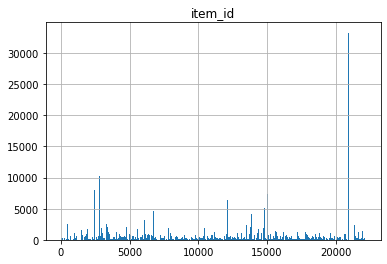

In [50]:
hist = df_sales.hist(column='item_id', bins=5000)

For counts above the 5000, the distbution is more separated and there are distinct spikes. But below 5000, the distribution is denser. Besides this, there does not seem to be any significant relation. 

**Note that** I tried to encode item_cnt_day to the order of item_ids by rearranging the item_id so that the order of item_ids is the same as order of total number item_cnt_day. One would expect that this would contribute to algorithms based on trees. But, the effect was small, decrease of rmse was around 0.02. I think this is because of the total count might be so effective given time-dependent changes.


But, of course, there is another more established way to encode transaction count based on item_id which is by mean_encoding. This is implemented in the feature engineering notebook.



In [51]:
df_sales['item_id'].value_counts()[:50]

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
7856      6602
3732      6475
2308      6320
4870      5811
3734      5805
1855      5681
5821      5389
16787     5283
6675      5122
7894      5107
2445      5056
1830      4976
5823      4974
6497      4904
5272      4853
13071     4804
6740      4675
3183      4615
4178      4527
2416      4487
7893      4380
6466      4324
6498      4278
6503      4274
6457      4269
1905      4164
1916      4106
3331      4057
6495      4006
5672      3942
6738      3881
6488      3794
12134     3763
4244      3696
3928      3568
3077      3533
6490      3505
2269      3503
3076      3464
4872      3456
1495      3419
3851      3396
5820      3395
2753      3374
4351      3334
Name: item_id, dtype: int64

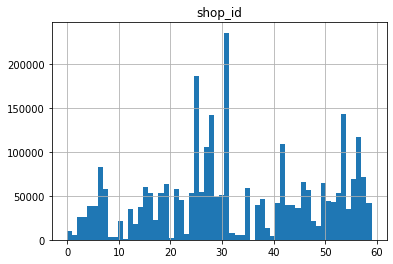

In [52]:
hist = df_sales.hist(column='shop_id', bins=60)

<Figure size 1440x1440 with 0 Axes>

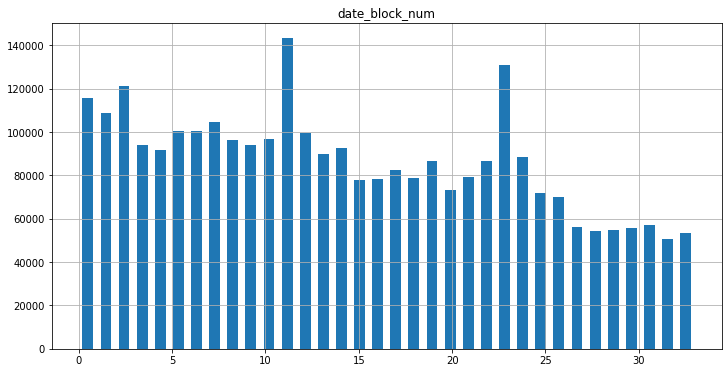

In [53]:
fig = plt.figure(figsize=(20,20))

hist = df_sales.hist(column='date_block_num', bins=34, rwidth=0.6, figsize=(12,6))

We see that there is a decrease in the total number of item_counts per month with peaks around the 12th month. This might correspond to chrismas, holiday period.

We can also look at the number of sales for each item, sales and categories

<BarContainer object of 24 artists>

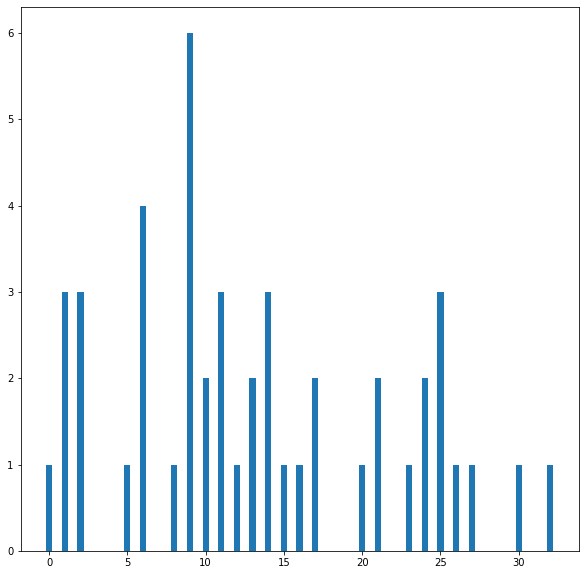

In [54]:
# for item_id == 1609
hist = df_sales.loc[df_sales.item_id==1609, ['date_block_num', 'item_cnt_day']].groupby(['date_block_num']).sum().reset_index()

fig = plt.figure(figsize=(10,10))
plt.bar(hist['date_block_num'], hist['item_cnt_day'],width = 0.4)

<BarContainer object of 34 artists>

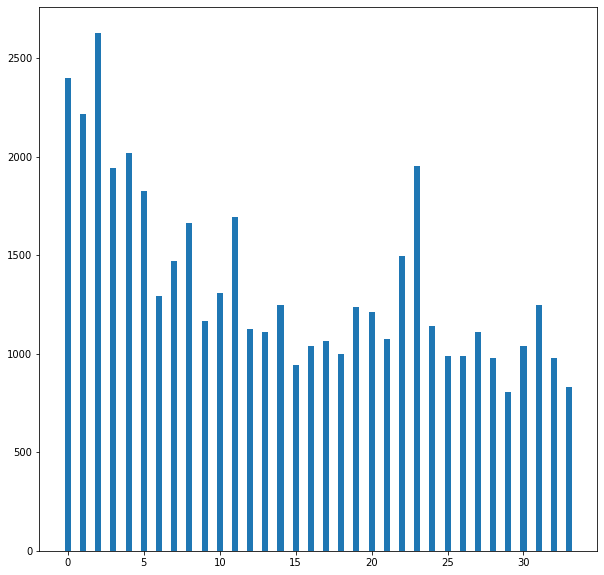

In [55]:
# for shop_id == 37
hist = df_sales.loc[df_sales.shop_id==37, ['date_block_num', 'item_cnt_day']].groupby(['date_block_num']).sum().reset_index()

fig = plt.figure(figsize=(10,10))
plt.bar(hist['date_block_num'], hist['item_cnt_day'],width = 0.4)

<BarContainer object of 34 artists>

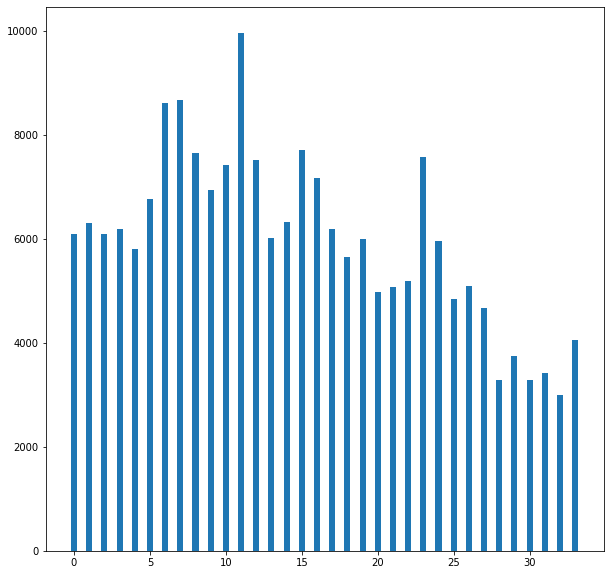

In [56]:
# for shop_id == 37
hist = df_sales.loc[df_sales.item_category_id==37, ['date_block_num', 'item_cnt_day']].groupby(['date_block_num']).sum().reset_index()

fig = plt.figure(figsize=(10,10))
plt.bar(hist['date_block_num'], hist['item_cnt_day'],width = 0.4)

Add Revenue of transaction
$$
\text{Revenue} = \text{number of items sold} \times \text{price}
$$

In [57]:
df_sales['revenue'] = df_sales.loc[:, 'item_price'] * df_sales.loc[:, 'item_cnt_day']

In [58]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,revenue
0,02.01.2013,0,59,22154,999.00,1.0,37,999.00
1,03.01.2013,0,25,2552,899.00,1.0,58,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,58,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,58,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,56,1099.00


Now add the revenues of each item, shop and category

In [59]:
df_items['revenue'] = df_sales[['item_id', 'revenue']].groupby(['item_id']).sum()
df_items.head()

,item_name,item_id,item_category_id,revenue
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,58.0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,26940.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,116.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,158.0
4,***КОРОБКА (СТЕКЛО) D,4,40,58.0


In [60]:
df_categories['revenue'] = df_items[['item_category_id', 'revenue']].groupby(['item_category_id']).sum()
df_categories.head(5)

,item_category_name,item_category_id,revenue
0,PC - Гарнитуры/Наушники,0,263.40
1,Аксессуары - PS2,1,431.00
2,Аксессуары - PS3,2,43564473.62
3,Аксессуары - PS4,3,62553530.39
4,Аксессуары - PSP,4,1332176.52


In [61]:
df_shops['revenue'] = df_sales[['shop_id', 'revenue']].groupby(['shop_id']).sum()
df_shops.head()

,shop_name,shop_id,revenue
0,"!Якутск Орджоникидзе, 56 фран",0,6.637370e+06
1,"!Якутск ТЦ ""Центральный"" фран",1,3.238207e+06
2,"Адыгея ТЦ ""Мега""",2,4.404964e+07
3,"Балашиха ТРК ""Октябрь-Киномир""",3,3.014085e+07
4,"Волжский ТЦ ""Волга Молл""",4,4.053965e+07


Revenue for individual item, category, shop

In [62]:
# for item_id == 1609
hist = df_sales.loc[df_sales.item_id==1609, ['date_block_num', 'revenue']].groupby(['date_block_num']).sum().reset_index()

<BarContainer object of 24 artists>

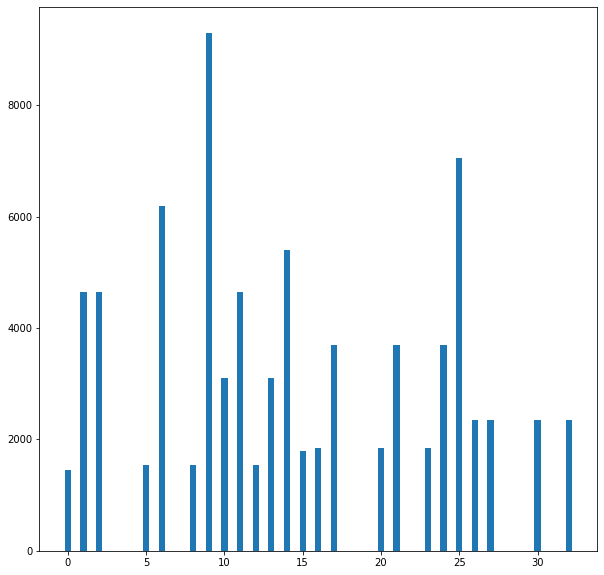

In [63]:
fig = plt.figure(figsize=(10,10))
plt.bar(hist['date_block_num'], hist['revenue'],width = 0.4)

In [64]:
# for shop_id == 37
hist = df_sales.loc[df_sales.shop_id==37, ['date_block_num', 'revenue']].groupby(['date_block_num']).sum().reset_index()

<BarContainer object of 34 artists>

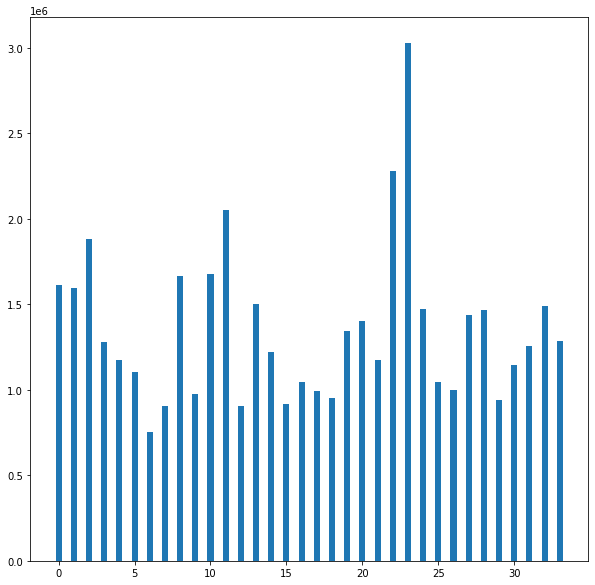

In [65]:
fig = plt.figure(figsize=(10,10))
plt.bar(hist['date_block_num'], hist['revenue'],width = 0.4)


In [66]:
# for item_category_id == 37
hist = df_sales.loc[df_sales.item_category_id==37, ['date_block_num', 'revenue']].groupby(['date_block_num']).sum().reset_index()

<BarContainer object of 34 artists>

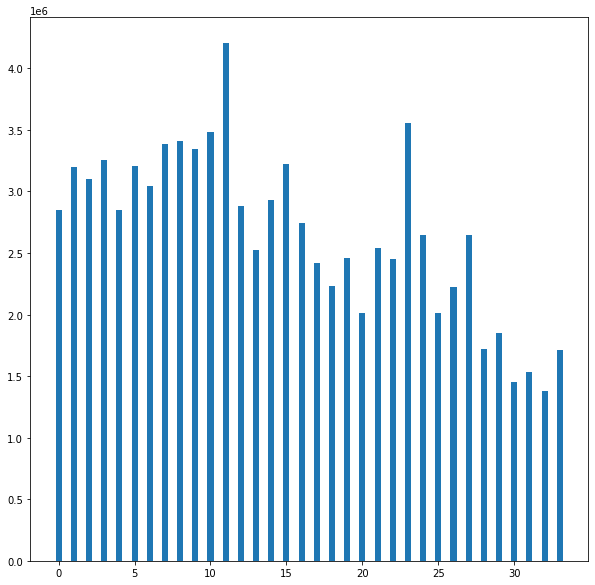

In [67]:
fig = plt.figure(figsize=(10,10))
plt.bar(hist['date_block_num'], hist['revenue'],width = 0.4)


## Posible sources of Outliers

### Prices
One possible source of outliers is price. This will be important since we will encode price fluctuations to our training data. So, let's look at the distribution of prices of each transaction

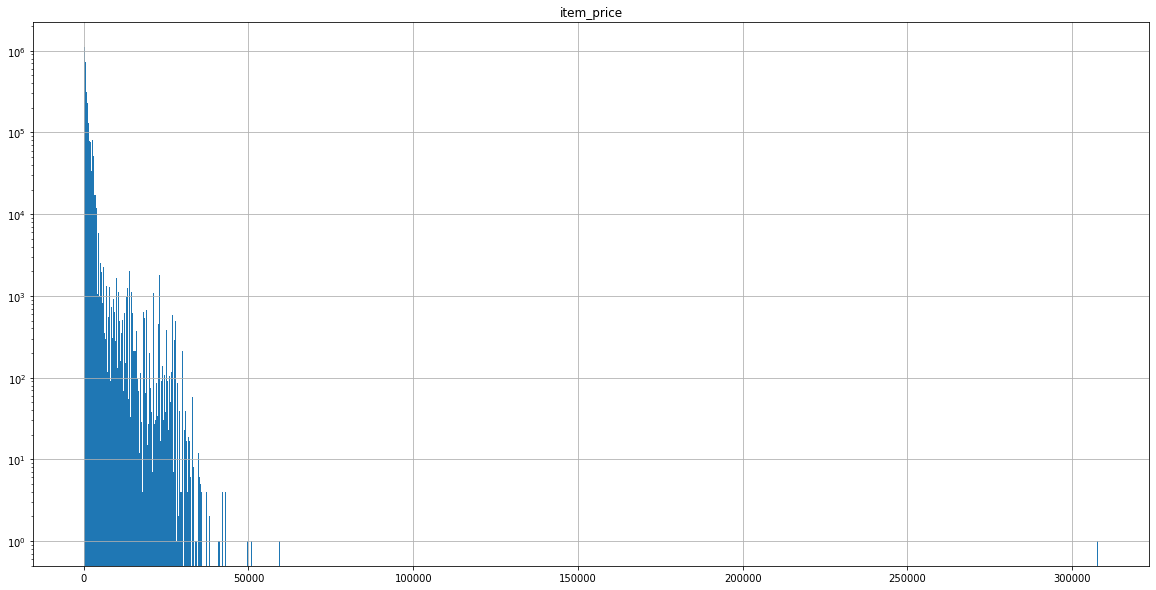

In [68]:
hist = df_sales.hist(column='item_price', bins=1000, figsize=(20,10), log=True)

From the price distribution, we see that some of prices are isolated from the others signficantly based on count, price > 30000. If we use price feature to train model, we will have to deal with these. Indeed, this is done in feature engineering notebook.

### Number of daily sales

Another possible source of outlier is the number of sales in a month. Thiis is also necessay since we will use it in mean encodings and it will be label to be predicted. This is even important given that the metric is root mean squared error

In [ ]:
hist = df_sales.groupby(['date_block_num', 'shop_id', 'item_id']).sum().hist(column='item_cnt_day', bins=1000, figsize=(20,10), log=True)

We see that after around 800-1000 the distribution of item_cnt_day is really isolated and probability is low, indicate that they are outliers.
We will discard these values when forming training points since data is big enough.